In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
baselines = pd.read_csv('Result playground - baselines.csv').rename(columns={
    'pmv_viol': 'PMV Violation',
    'illum_viol': 'Illum Violation',
    'power': 'Power'
})

In [4]:
def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

In [5]:
names = {
    'Power': 0,
    'PMV Mean': 1,
    'PMV Violation': 2,
    'Illum Mean': 3,
    'Illum Violation': 4,
}

In [6]:
df = pd.read_csv(f'Result playground - dqn.csv', index_col=False).fillna(method='ffill')
df = df.dropna(axis='columns')
cases = df['Unnamed: 0'].unique()

In [110]:
def get_baseline(case):
    bls = baselines.copy()
    season = 'heating' if 'heating' in case else 'cooling'
    blinds = 'Blinds: None' if 'NoBlindCtrl' in case else 'Blinds: All'
    dim    = 'AutoDim: False' if 'NoAutoDim' in case else 'AutoDim: True'
    bls = bls[bls['season'] == season]
    bls = bls[bls['case'].str.contains(blinds)]
    bls = bls[bls['case'].str.contains(dim)]
    return bls

def get_rps_on_pareto(x_pareto, y_pareto, ):
    df_case = df[df['Unnamed: 0'] == c]
    cols_1 = set(df.columns[df_case.isin(x_pareto).any()])
    cols_2 = set(df.columns[df_case.isin(y_pareto).any()])
    cols =  list(cols_1 & cols_2)
    info = {
        'rps': cols,
        'Power': list(df_case[cols].iloc[[names['Power']]].values[0]),
        'PMV Mean': list(df_case[cols].iloc[[names['PMV Mean']]].values[0]),
        'PMV Violation': list(df_case[cols].iloc[[names['PMV Violation']]].values[0]),
        'Illum Mean': list(df_case[cols].iloc[[names['Illum Mean']]].values[0]),
        'Illum Violation': list(df_case[cols].iloc[[names['Illum Violation']]].values[0]),
    }
    return info

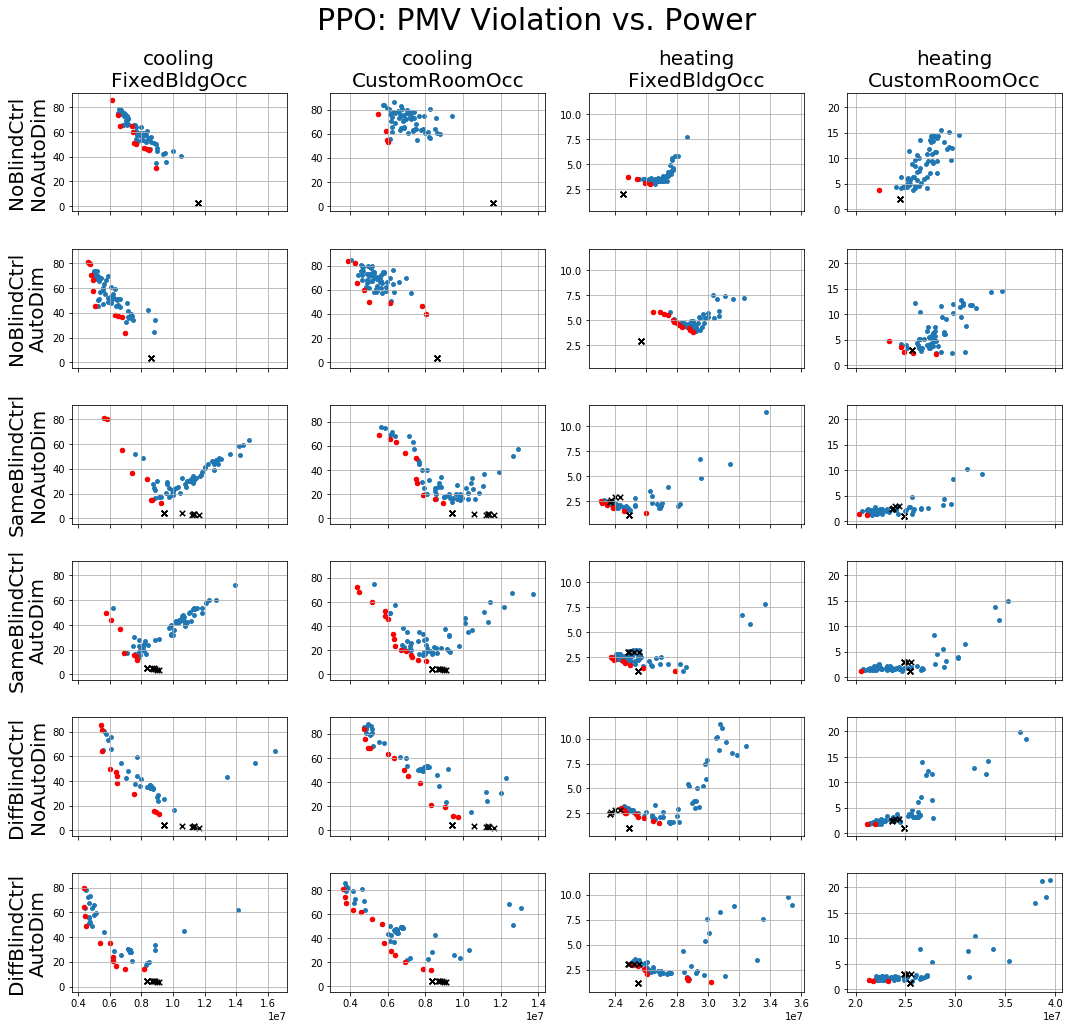

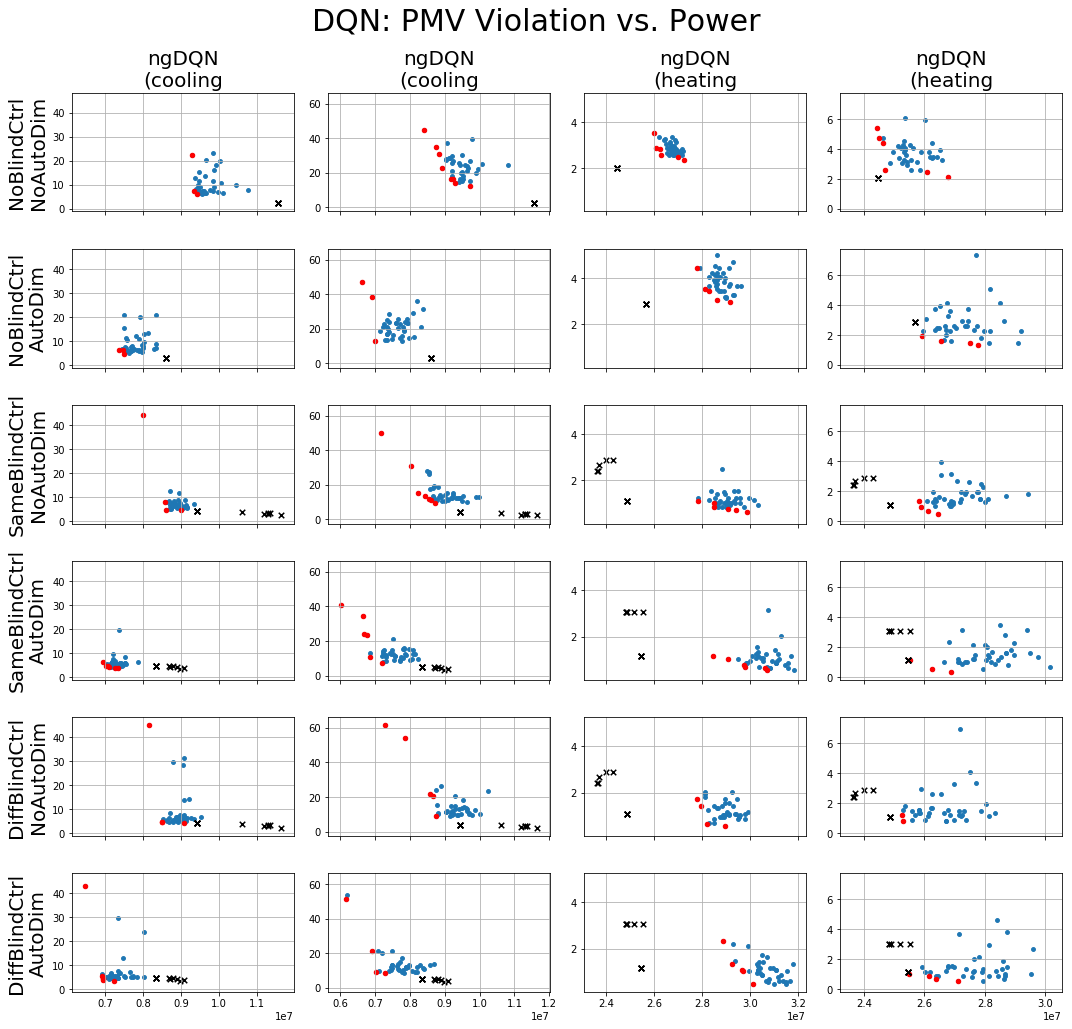

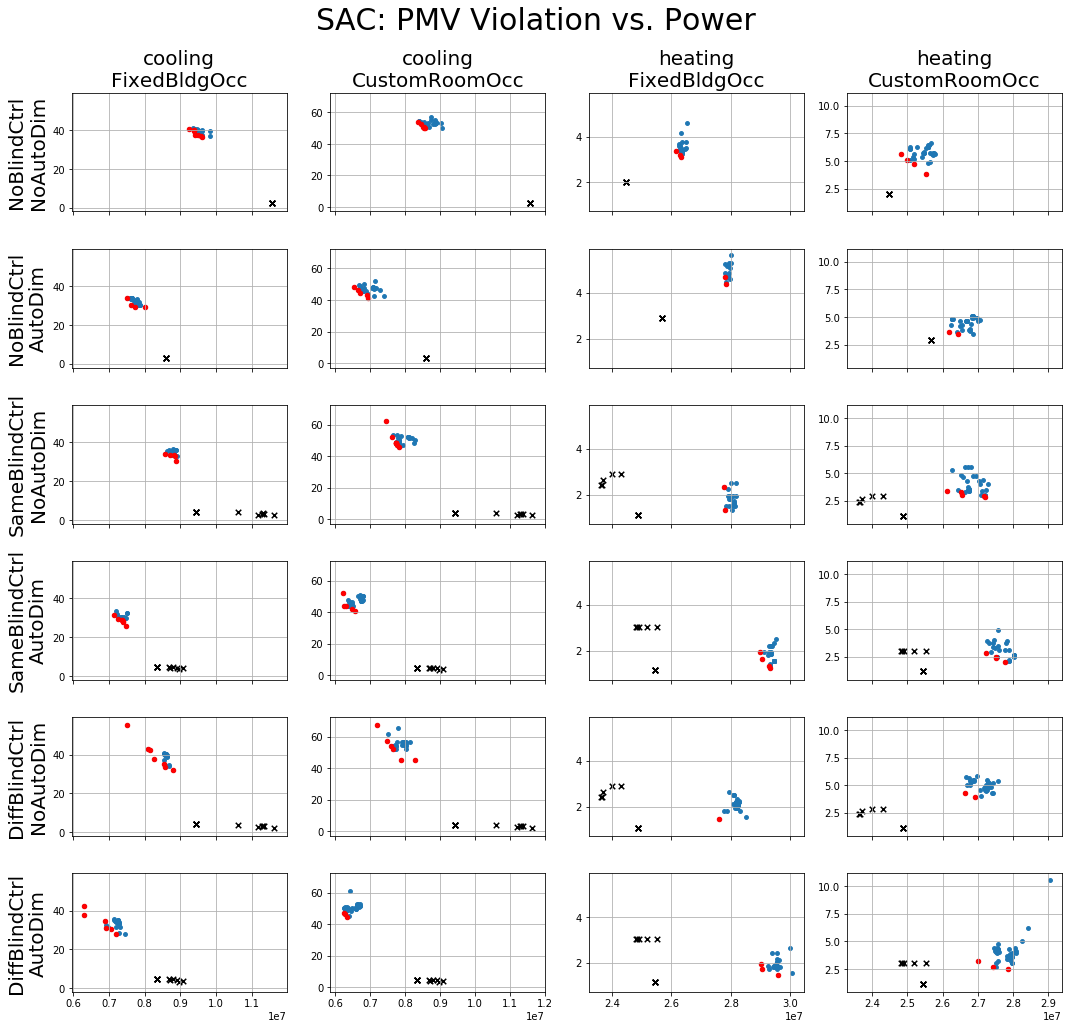

In [121]:
all_paretos = {}
for agent in ['ppo', 'dqn', 'sac']:
    agent_paretos = {}
    df = pd.read_csv(f'Result playground - {agent}.csv', index_col=False).fillna(method='ffill')
    df = df.dropna(axis='columns')
    cases = df['Unnamed: 0'].unique()

    n1 = 'Power'
    n2 = 'PMV Violation'
    fig, axes = plt.subplots(24//4, 4, figsize=(15,15), sharex='col', sharey='col')
    title = f"{agent.upper()}: {n2} vs. {n1}"
    plt.suptitle(title, fontsize=30)
    i = -1
    for c in cases:
        info = c.split(' ')
        i += 1
        if 'cooling FixedBldgOcc' in c:
            j = 0
        elif 'cooling CustomRoomOcc' in c:
            j = 1
        elif 'heating FixedBldgOcc' in c:
            j = 2
        elif 'heating CustomRoomOcc' in c:
            j = 3
        ax = axes[i%6,j]

        x_agent = df[df['Unnamed: 0'] == c].iloc[[names[n1]]].values[0][1:]
        y_agent = df[df['Unnamed: 0'] == c].iloc[[names[n2]]].values[0][1:]
        scores = np.stack((x_agent, y_agent), axis=1) #.reshape(-1)
        scores = np.delete(scores, np.where(scores[:,0] <= 0), axis=0)
        
        ax.scatter(scores[:,0], scores[:,1], s=15)

        # Pareto Front
        pareto = identify_pareto(scores)
        pareto_front = scores[pareto]
        
        pareto_front_df = pd.DataFrame(pareto_front)
        pareto_front_df.sort_values(0, inplace=True)
        pareto_front = pareto_front_df.values
        x_pareto = pareto_front[:, 0]
        y_pareto = pareto_front[:, 1]

        agent_paretos[c] = get_rps_on_pareto(x_pareto, y_pareto)

        ax.scatter(x_pareto, y_pareto, color='r', s=20)
        if j == 0:
            ax.set_ylabel(f'{info[-2]}\n{info[-1]}', fontsize=20)
        if i%6 == 0:
            ax.set_title(f'{info[0]}\n{info[1]}', fontsize=20)
            
        # Plot Baselines
        bls = get_baseline(c)
        ax.scatter(bls[n1].values, bls[n2].values, color='black', s=30,  marker='x')
        ax.grid()
    all_paretos[agent] = agent_paretos
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'{title}.png') 

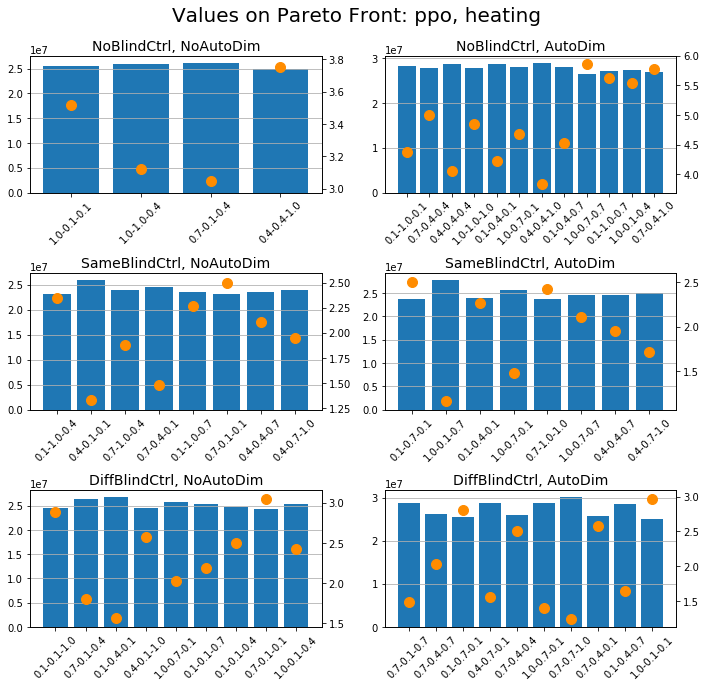

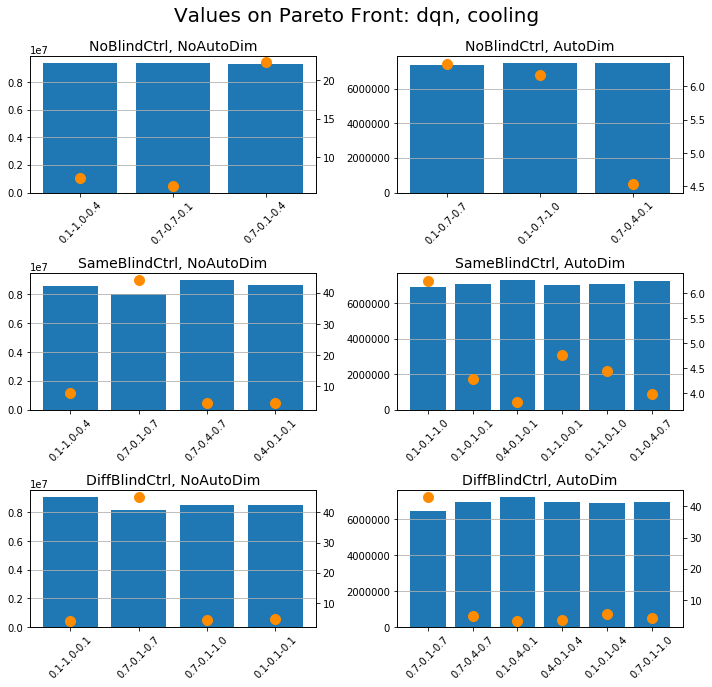

In [227]:
# Chose these based on the pareto fronts:
bests = [('ppo', 'heating'), ('dqn', 'cooling')]

for agent, season in bests:
    d = all_paretos[agent]
    fig, axes = plt.subplots(3, 2, figsize=(10,10))
    plt.suptitle(f'Values on Pareto Front: {agent}, {season}', fontsize=20)
    i = 0
    for key, value in d.items():
        if (season in key) and ('FixedBldgOcc' in key):
            keys = key.split(' ')
            ax = axes[i//2,i%2]
            ax.set_title(f'{keys[-2]}, {keys[-1]}', fontsize=14)
            ax.bar(value['rps'], value['Power'], label='Power')
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)
            ax1 = ax.twinx()
            ax.grid(axis='y')
            ax1.scatter(value['rps'], value['PMV Violation'], marker='o', s = 100, c='darkorange', label='PMV')
            i += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'rps on paretos, {agent}, {season}.png')